In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
train_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/train/train"
validation_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/validation/validation"
test_dir = "/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test"

creating data generators

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)  
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
df = pd.read_csv("/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
None_of_the_Above        81
1400Ripples              81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

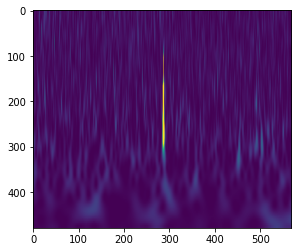

In [6]:
fullpath = train_dir + "/Blip/" + os.listdir(train_dir + "/Blip")[0]
img = mpimg.imread(fullpath)
plt.imshow(img)

getting the class names

In [7]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)
classes_list

['Blip',
 'Koi_Fish',
 'Low_Frequency_Burst',
 'Light_Modulation',
 'Power_Line',
 'Extremely_Loud',
 'Low_Frequency_Lines',
 'Scattered_Light',
 'Violin_Mode',
 'Scratchy',
 '1080Lines',
 'Whistle',
 'Helix',
 'Repeating_Blips',
 'No_Glitch',
 'Tomte',
 'None_of_the_Above',
 '1400Ripples',
 'Chirp',
 'Air_Compressor',
 'Wandering_Line',
 'Paired_Doves']

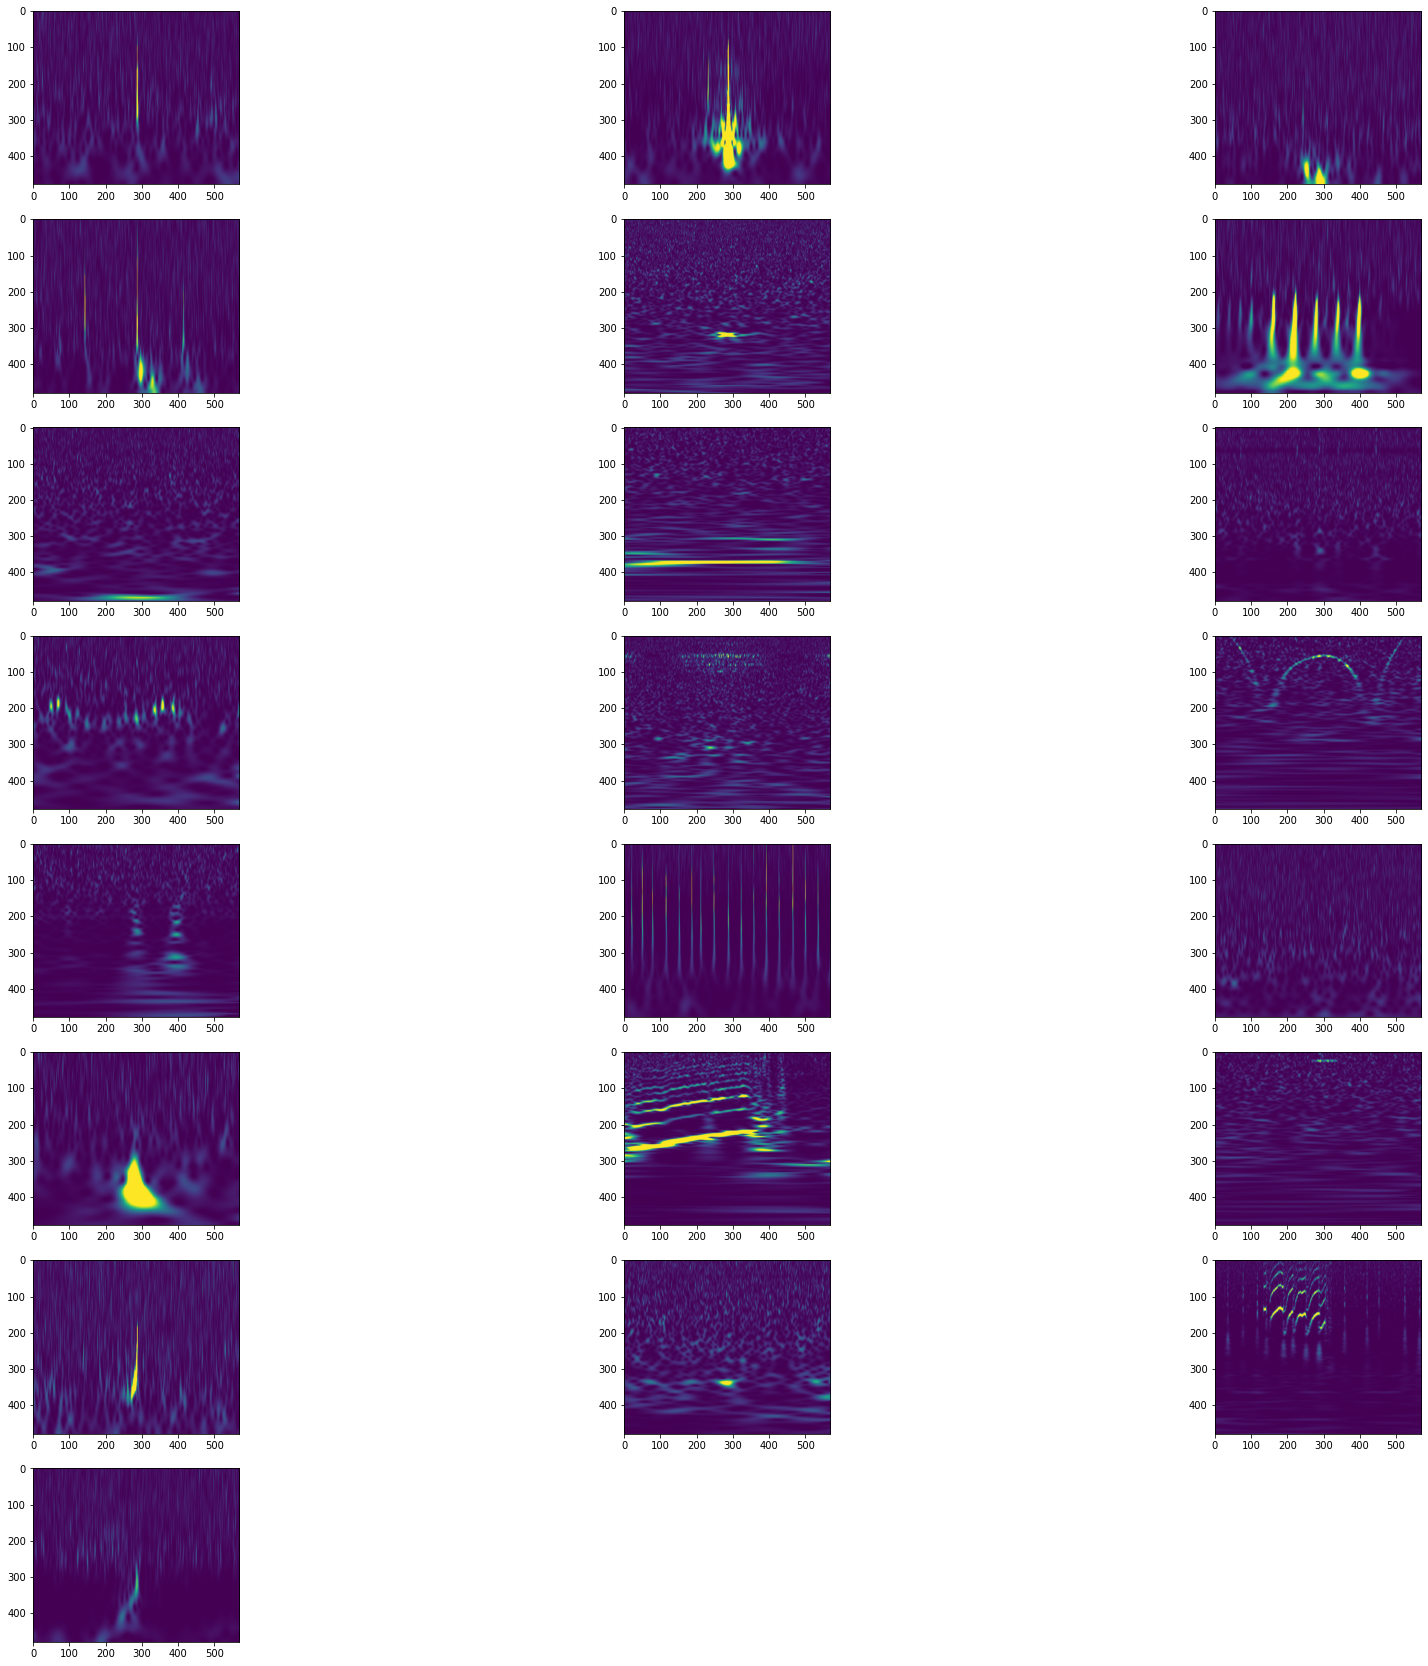

In [8]:
plt.figure(figsize=(30, 30))
    
for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + "/" + classes_list[i] + '/' + os.listdir(train_dir + "/" + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

In [9]:
training_batch_size = 10
validation_batch_size = 10
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  classes = classes_list,
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 2417 images belonging to 22 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 1168 images belonging to 22 classes.


In [11]:
test_size = !find '/content/drive/MyDrive/AdLab_CaseStudy_Dataset/gravitational-spy/test/test' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 1258 images belonging to 22 classes.


In [12]:
input_shape = (img_dim, img_dim, 3)

base_model = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape = input_shape
)
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

model.layers[0].trainable = False

model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.AUC(name='accuracy')]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
Total params: 87,990,334
Trainable params: 67,124,758
Non-trainable params: 20,865,576
___________________________________

In [13]:
training_step_size = 32
validation_step_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    mode = "max",
    patience = 6
)
history = model.fit(
    train_generator,
    steps_per_epoch = training_step_size,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = validation_step_size,
    callbacks = [early_stopping],
    verbose = 1,
)

print("Training Done")
model.save("Xception-Glitch.h5")

Epoch 1/100
32/32 [==============================] - 339s 11s/step - loss: 33.7382 - accuracy: 0.6677 - val_loss: 26.5304 - val_accuracy: 0.5647
Epoch 2/100
32/32 [==============================] - 275s 9s/step - loss: 14.7368 - accuracy: 0.7552 - val_loss: 11.1380 - val_accuracy: 0.7320
Epoch 3/100
32/32 [==============================] - 211s 7s/step - loss: 6.2769 - accuracy: 0.8427 - val_loss: 4.8241 - val_accuracy: 0.8412
Epoch 4/100
32/32 [==============================] - 175s 6s/step - loss: 2.9757 - accuracy: 0.9006 - val_loss: 2.9144 - val_accuracy: 0.8747
Epoch 5/100
32/32 [==============================] - 147s 5s/step - loss: 2.0533 - accuracy: 0.9121 - val_loss: 3.0417 - val_accuracy: 0.8585
Epoch 6/100
32/32 [==============================] - 119s 4s/step - loss: 1.9596 - accuracy: 0.9298 - val_loss: 1.8976 - val_accuracy: 0.9317
Epoch 7/100
32/32 [==============================] - 97s 3s/step - loss: 1.4618 - accuracy: 0.9464 - val_loss: 1.8869 - val_accuracy: 0.9273
Ep

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [31]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [15]:
# test_scores = model.evaluate(test_generator, steps = test_size, verbose = 1)

1258/1258 [==============================] - 687s 547ms/step - loss: 3.0385 - accuracy: 0.8682


In [16]:

# print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Testing Accuracy: 86.82%


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

classes = classes_list
train_hist = history
test_gen = test_generator

y_actual = test_generator.classes

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)

# Evaluate the results:
test_loss, test_metric = model.evaluate(test_gen,verbose = False)
results       = test_metric*100 
results_title ="\n Model Accuracy on Test Data:{}%".format(results)
print(results_title.format(results))
print(len(results_title) * "-")
    
# print classification report
print(classification_report(y_actual, y_pred, target_names=classes))


 Model Accuracy on Test Data:86.824631690979%
----------------------------------------------
                     precision    recall  f1-score   support

               Blip       0.67      0.04      0.07       170
           Koi_Fish       0.78      0.76      0.77       100
Low_Frequency_Burst       0.00      0.00      0.00         0
   Light_Modulation       0.86      0.19      0.31       100
         Power_Line       0.00      0.00      0.00         0
     Extremely_Loud       0.66      0.95      0.78        80
Low_Frequency_Lines       0.00      0.00      0.00         0
    Scattered_Light       0.87      0.86      0.86       100
        Violin_Mode       0.46      0.50      0.48       100
           Scratchy       0.77      0.88      0.82       100
          1080Lines       0.94      0.12      0.21       130
            Whistle       0.00      0.00      0.00         0
              Helix       0.69      0.64      0.66       100
    Repeating_Blips       0.54      0.74      0.62 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# extract data from training history for plotting
history_dict    = train_hist.history
loss_values     = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values      = history_dict['accuracy']
val_accuracy_values  = history_dict['val_accuracy']
epochs          = range(1, len(history_dict['accuracy']) + 1)

# get the min loss and max accuracy for plotting
max_acc = np.max(val_accuracy_values)
min_loss = np.min(val_loss_values)
    

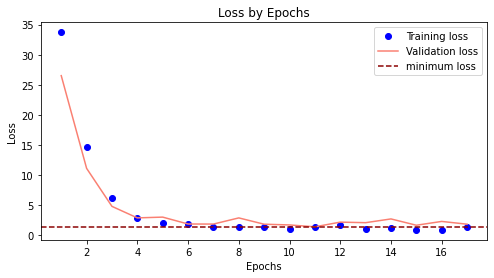

In [27]:
# create plots
plt.subplots(figsize=(8,4))

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'salmon', label = 'Validation loss')
plt.title('Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(y=min_loss,color='darkred', linestyle='--', label = "minimum loss")
plt.legend()

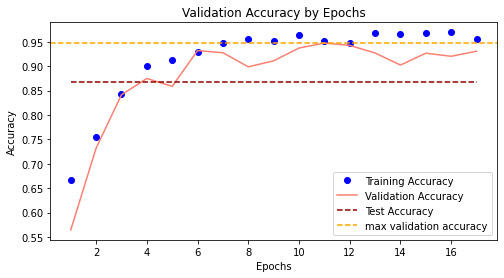

In [30]:
plt.subplots(figsize=(8,4))
plt.plot(epochs, acc_values, 'bo',label = 'Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'salmon', label = 'Validation Accuracy')
plt.plot(epochs,[results/100]*len(epochs),'darkred',linestyle = '--',label='Test Accuracy')
plt.title('Validation Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.axhline(y=max_acc,color='orange', linestyle='--', label = "max validation accuracy")
plt.legend()

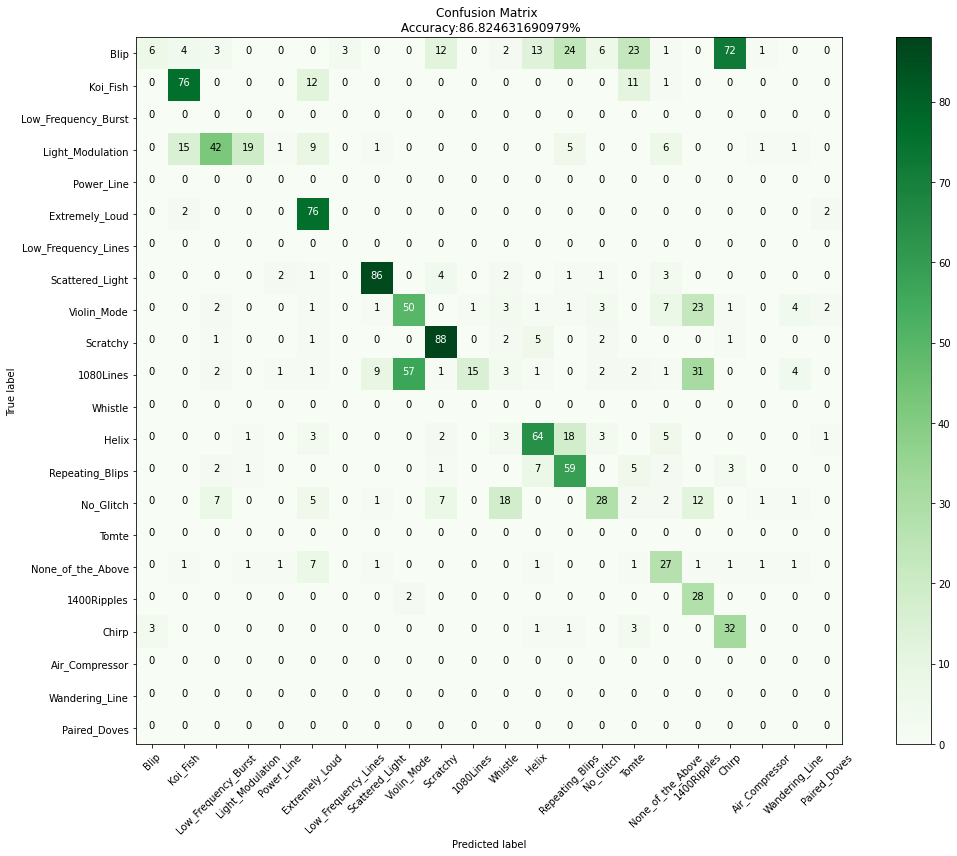

In [29]:
# calculate Confusion Matrix
cm = confusion_matrix(y_actual, y_pred)

# create confusion matrix plot
plt.subplots(figsize=(16,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix \n Accuracy:{}%".format(results))
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# loop through matrix, plot each 
threshold = cm.max() / 2.
for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(c, r, format(cm[r, c], 'd'),
              horizontalalignment="center",
              color="white" if cm[r, c] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()